In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from check_mean_reversion import check_mean_reversion,  plot_adx_mr, compute_indicators_mean_reversion, plot_price_with_sma_crosses
from check_trend_following import check_trend_following, plot_autocorrelation, plot_adx, plot_sma_trend
from calendar_analysis import analyze_calendar_effects
from check_outliers import detect_outliers, plot_outliers
from pattern_up_down import analyze_up_down
import math



## Khởi tạo ban đầu

In [2]:
# Đường dẫn folder chứa dữ liệu
base_folder = r'C:\\Users\\Dinh Binh An\\OneDrive\\Dai_hoc\\toan_tai_chinh\\giua_ki\\Data'

# Đường dẫn file
file_path = os.path.join(base_folder, 'KO.csv')

df_main = pd.read_csv(file_path, parse_dates=['Date'])
df_main = df_main.sort_values('Date').reset_index(drop=True)

print(f"Data shape: {df_main.shape}")
print(f"Date range: {df_main['Date'].min()} to {df_main['Date'].max()}")

Data shape: (5030, 8)
Date range: 2005-10-03 00:00:00-04:00 to 2025-09-30 00:00:00-04:00


In [3]:
start_date = df_main['Date'].min()
split_date = start_date + pd.DateOffset(years=10)

# Dữ liệu cho EDA & train
df = df_main[df_main['Date'] < split_date].copy()


print("EDA:")
print(f"  Shape: {df.shape}")
print(f"  Date range: {df['Date'].min()} → {df['Date'].max()}")




EDA:
  Shape: (2518, 8)
  Date range: 2005-10-03 00:00:00-04:00 → 2015-10-02 00:00:00-04:00


# Khám phá dữ liệu

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2005-10-03 00:00:00-04:00,11.682285,11.749875,11.657953,11.682285,13063800,0.0,0.0
1,2005-10-04 00:00:00-04:00,11.725541,11.787724,11.628211,11.636323,9836800,0.0,0.0
2,2005-10-05 00:00:00-04:00,11.614695,11.674174,11.522772,11.522772,10305600,0.0,0.0
3,2005-10-06 00:00:00-04:00,11.530888,11.593071,11.474111,11.547109,13721400,0.0,0.0
4,2005-10-07 00:00:00-04:00,11.528184,11.536294,11.365968,11.409225,14741800,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2518 entries, 0 to 2517
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2518 non-null   object 
 1   Open          2518 non-null   float64
 2   High          2518 non-null   float64
 3   Low           2518 non-null   float64
 4   Close         2518 non-null   float64
 5   Volume        2518 non-null   int64  
 6   Dividends     2518 non-null   float64
 7   Stock Splits  2518 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 177.0+ KB


In [6]:
# Kiểm tra missing data
df.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [7]:
# kiểm tra dữ liệu trùng lặp
df.duplicated().sum()

np.int64(0)

In [8]:
# Chuyển cột Date sang kiểu Datetime
df['Date'] = pd.to_datetime(df['Date'], utc = True)

Số outlier: 6
Danh sách các outlier: 
| Date       |    Open |    High |     Low |   Close |   Volume |   Dividends |   Stock Splits |     return | is_outlier   |   qq_deviation |
|:-----------|--------:|--------:|--------:|--------:|---------:|------------:|---------------:|-----------:|:-------------|---------------:|
| 2008-10-09 | 13.9326 | 13.9502 | 12.682  | 12.682  | 46288400 |           0 |              0 | -0.0866905 | True         |        3.91751 |
| 2008-10-13 | 12.7201 | 13.9209 | 12.6557 | 13.8419 | 50478400 |           0 |              0 |  0.138795  | True         |        8.30452 |
| 2008-10-14 | 13.795  | 13.795  | 12.4916 | 12.808  | 57665600 |           0 |              0 | -0.0746929 | True         |        3.19136 |
| 2008-10-28 | 12.1724 | 13.2737 | 12.0435 | 13.2532 | 36079600 |           0 |              0 |  0.10339   | True         |        5.57421 |
| 2008-11-21 | 12.1958 | 12.972  | 11.8619 | 12.887  | 50104800 |           0 |              0 |  0.0713416 | 

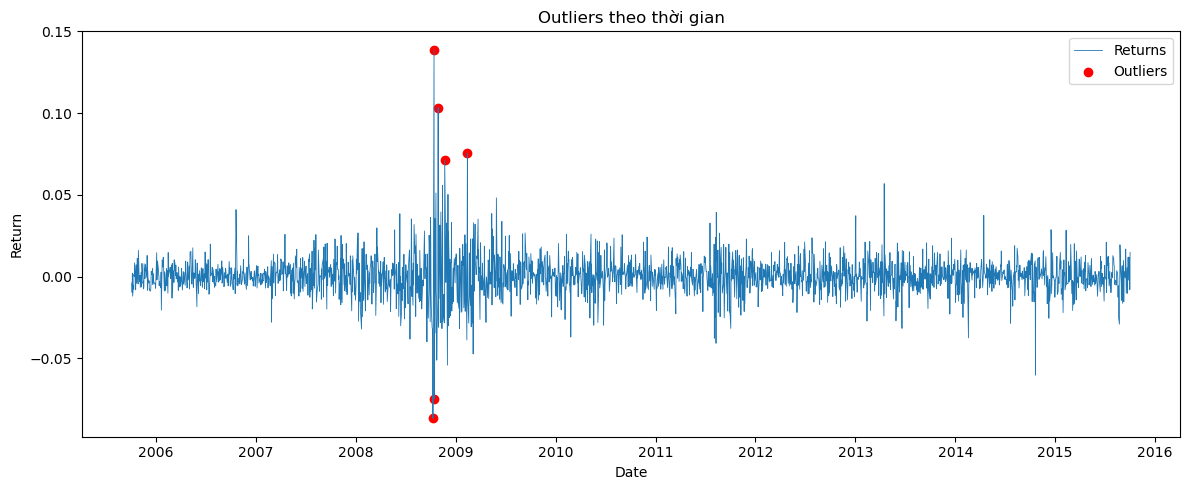

In [9]:
# Kiểm tra outlier
result = detect_outliers(df, price_col='Close', threshold=3)

print("Số outlier:", result['outliers'].shape[0])
print("Danh sách các outlier: ")
print(result['outliers'].to_markdown())

# Trực quan các outlier
plot_outliers(result['df'])




**Nhận xét**:

- Dựa trên phương pháp sử dụng QQ-plot (Quantile-Quantile plot) và độ lệch chuẩn, hệ thống phát hiện được 6 outlier có biến động lợi nhuận (return) cực đoan. Trong đó, các ngày có mức giảm sâu nhất là 2008-10-09 và 2008-10-14, cùng các ngày có mức tăng vọt như 2008-10-13 và 2008-10-28.

- Đặc biệt, tất cả các outlier này đều tập trung vào giai đoạn cuối năm 2008 và đầu năm 2009. Nguyên nhân chính là do tác động của Cuộc khủng hoảng tài chính toàn cầu 2008, khiến thị trường chứng khoán biến động cực kỳ mạnh (volatility cao), dẫn đến giá cổ phiếu Coca-Cola có những phiên nhảy vọt hoặc sụt giảm bất thường.

- Ở đây, ta không xử lý (không loại bỏ) các outlier này vì chúng không phải là lỗi nhập liệu mà là kết quả của các sự kiện kinh tế thực tế. 


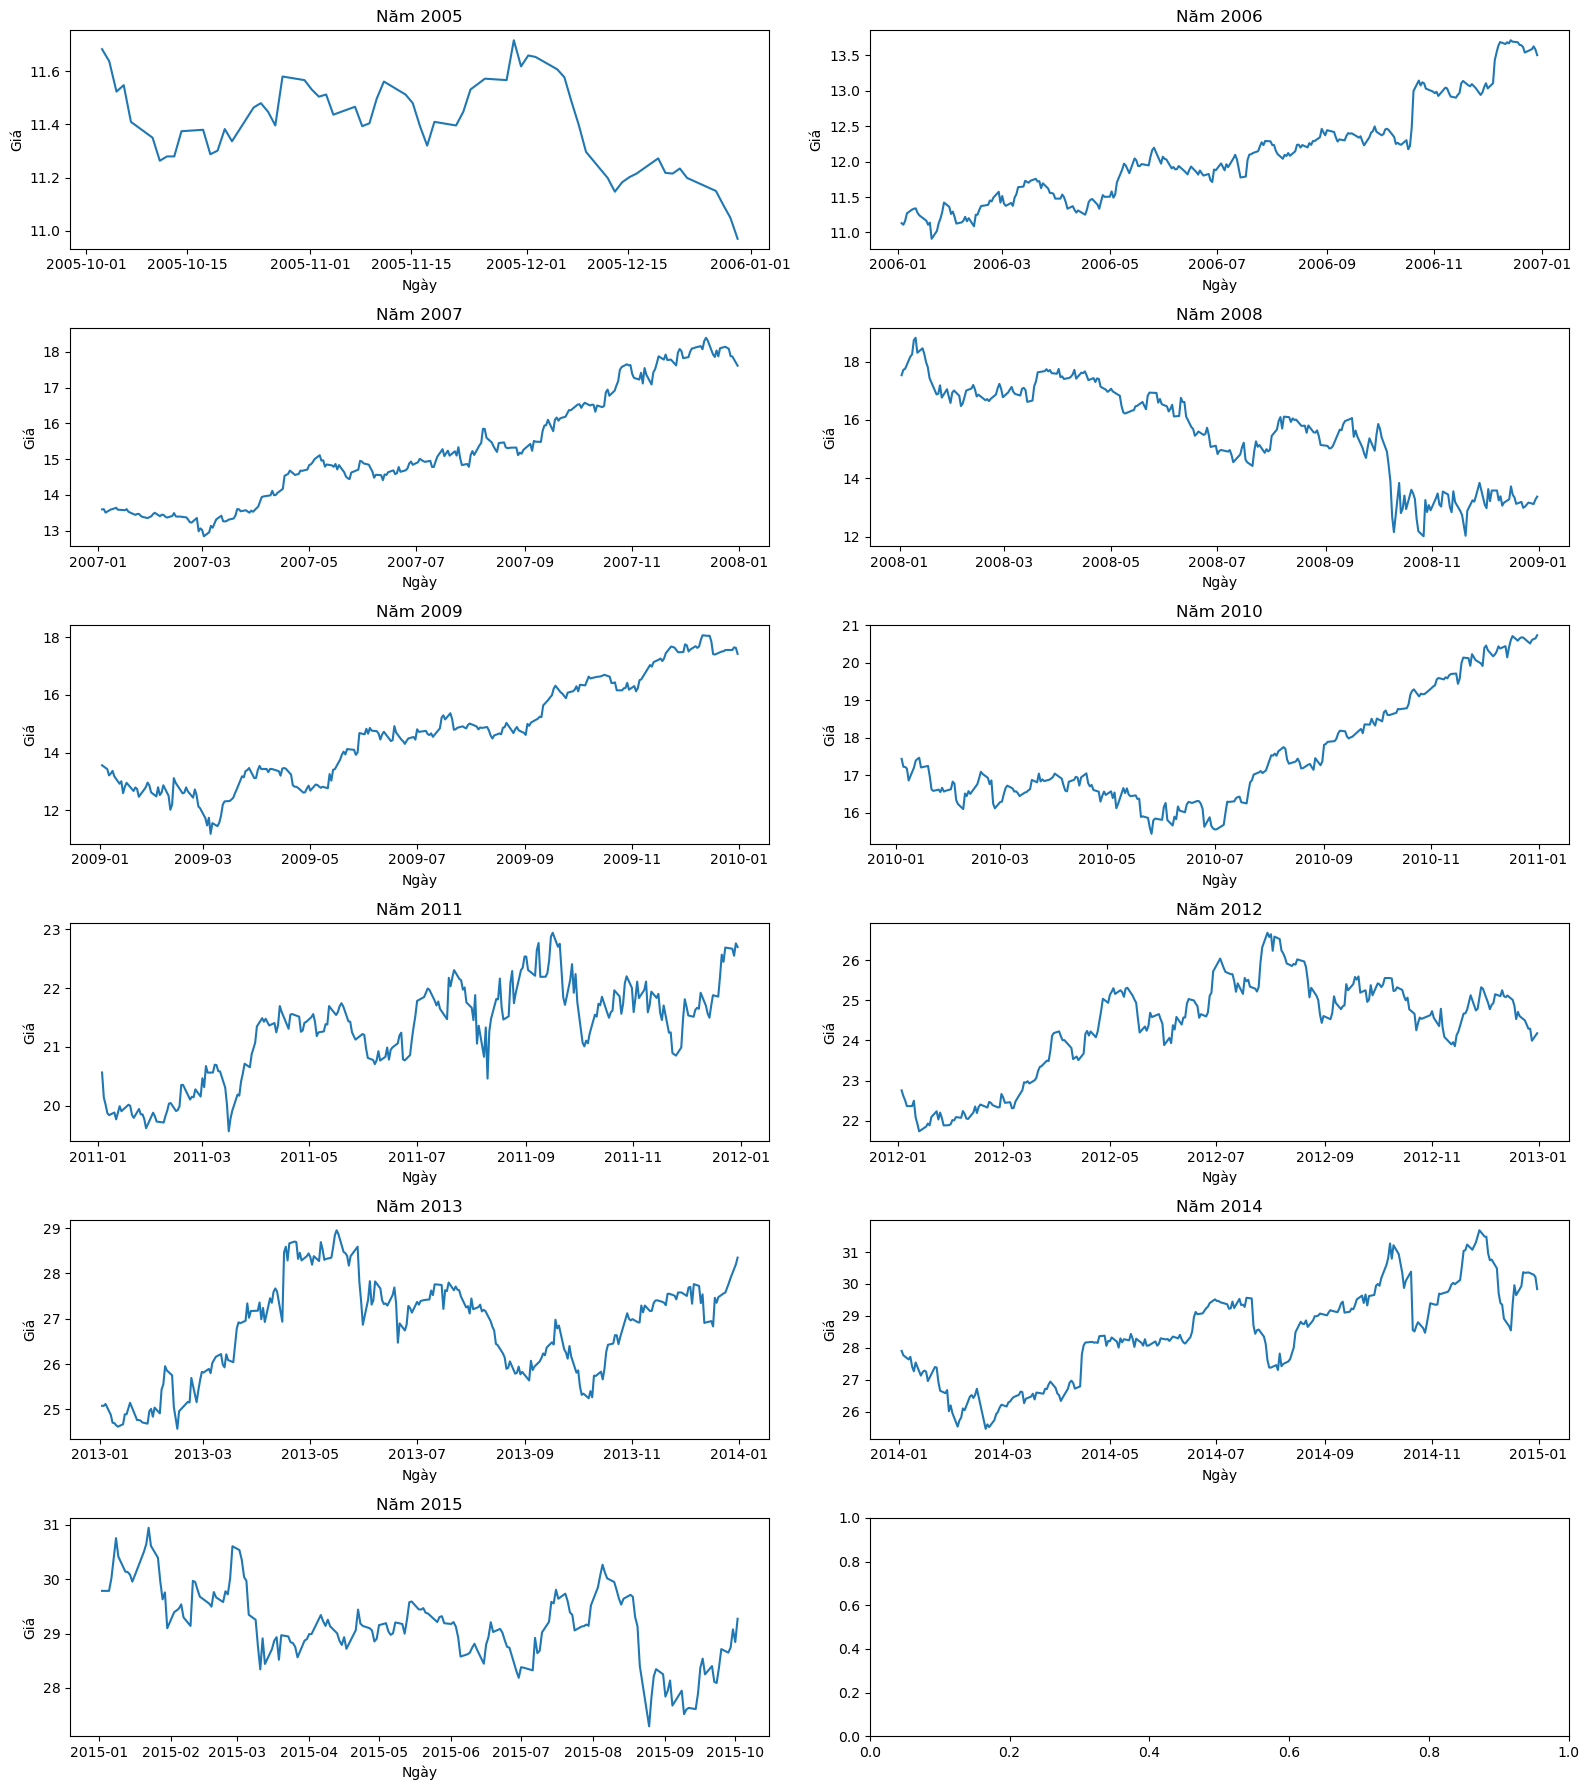

In [10]:
# Giá tăng theo từng năm

years = sorted(df['Date'].dt.year.unique())

num_years = len(years)
cols = 2
rows = math.ceil(num_years / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 18), sharex=False, sharey=False)
axes = axes.flatten()  # đơn giản hóa truy cập

for idx, year in enumerate(years):
    df_year = df[df['Date'].dt.year == year]
    ax = axes[idx]

    ax.plot(df_year['Date'], df_year['Close'])
    ax.set_title(f"Năm {year}", fontsize=12)
    ax.set_xlabel("Ngày")
    ax.set_ylabel("Giá")

plt.tight_layout()
plt.show()

## Kiểm tra cổ phiếu có pattern trend-following 

**Các điều kiện kiểm tra**:

- AutoCorrelation > 0 (1)
  
- median ADX > 25 (2)

- Tỷ lệ thời gian giá trên/dưới SMA trung hạn (SMA 50) (3)

**Giải thích**:

- (1): Nếu cổ phiếu có pattern trend-following thì nếu giá ngày trước giá tăng/giảm thì ngày sau có xu hướng tiếp tục theo cùng hướng. Nên AutoCorrelation  > 0 thể hiện tương quan dương giữa returns tại thời điểm t và t+1..
  
- (2): ADX là dùng để đo độ mạnh xu hướng, không xét tăng hay giảm. Giá biến động nhiều mà không có xu hướng rõ thì chiến lược trend-following sẽ kém hiệu quả. ADX > 25 là ngưỡng thường được dùng để kiểm tra "trend mạnh".

- (3): Nếu cổ phiếu thực sự có trend ổn định thì phần lớn giá sẽ nằm trên/dưới đường SMA trung hạn. Tức là giá nó tăng/giảm bền vững ít bị nhiễu.


autocorr: -0.07382296912252219
adx_median: 21.240951074401796
pct_close_above_SMA50: 0.6012708498808578
pct_close_below_SMA50: 0.37926926131850675
SMA50_slope: 0.008131188362927661
trend_direction: up


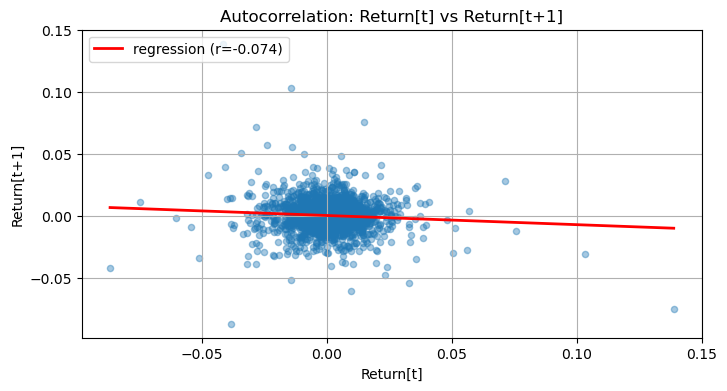

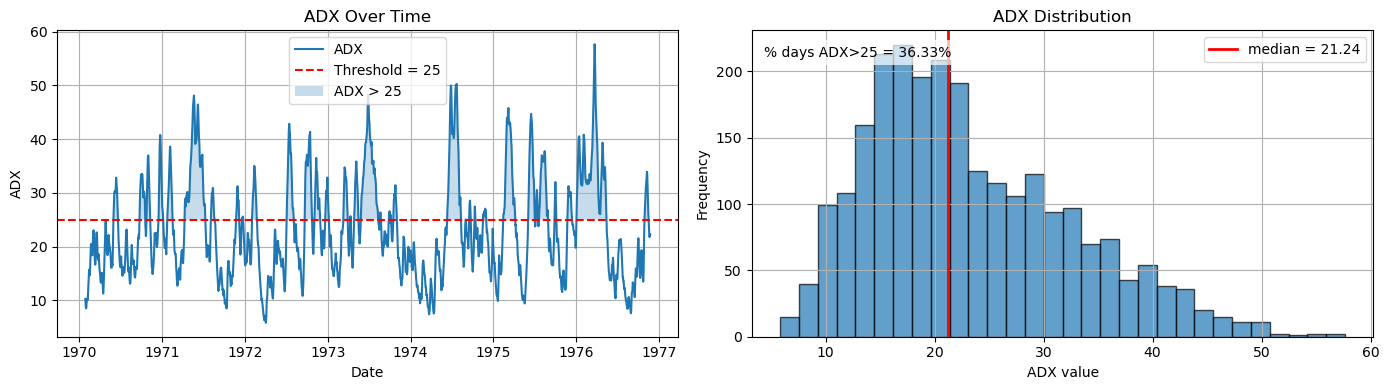

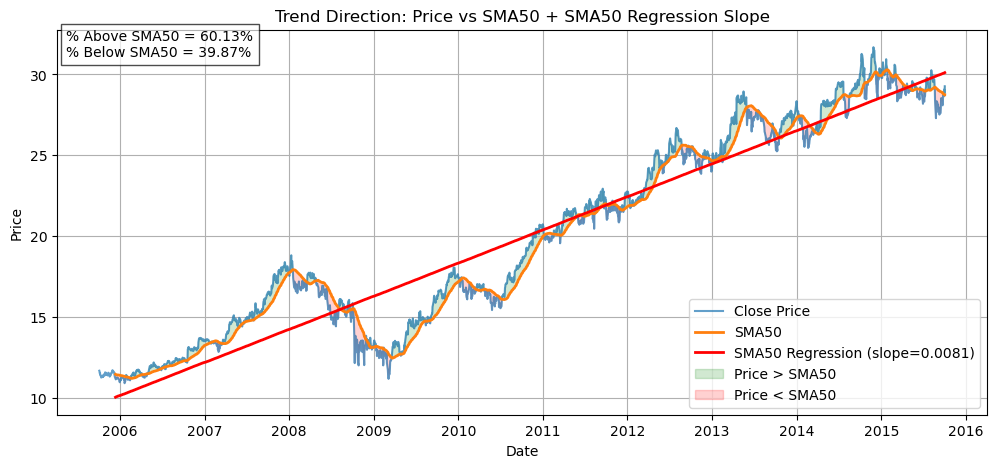

In [11]:
# Kiểm tra cổ phiếu có pattern trend-following không
results = check_trend_following(df)

for k, v in results.items():
    print(f"{k}: {v}")

# Trực quan hóa
plot_autocorrelation(df)
plot_adx(df)
plot_sma_trend(df)



**Nhận xét**:

+ autocorr = -0.07382 < 0 : giá không có xu hương duy trì đà của nó
  
+ adx_median = 21.24095 < 25 :  Xu hướng không đủ mạnh

+ SMA50_slope:  0.00813 => Có xu hướng trung bình đang đi lên nhưng mà yếu

+ pct_close_above_SMA50 = 0.60127 => chưa đủ nhiều

+ pct_close_below_SMA50 = 0.37926

**Kết luận**: 

Cổ phiếu chưa đủ cơ sở để chứng minh có pattern trend-following 

## Kiểm tra cổ phiếu có pattern mean-reversion 

Điều kiện cần xét:

- AutoCorrelation < 0 (1)

- median ADX < 20 (2)

- Số lần trung bình giá cắt SMA trung hạn (SMA 50) trong năm (3)

Giải thích:

- (1): Nếu cổ phiếu có pattern mean-reversion thì khi giá tăng mạnh trong một ngày, ngày sau có xu hướng giảm lại, và ngược lại. Nên AutoCorrelation < 0 thể hiện bằng tương quan âm giữa returns tại thời điểm t và t+1.

- (2): Với cổ phiếu có pattern mean-reversion, nó không có xu hướng rõ ràng, vì khi trend mạnh thì giá ít quay lại mức trung bình. Ngưỡng ADX < 20 thường được dùng để xác định thị trường sideway / yếu xu hướng.

- (3) Nếu cổ phiếu có pattern mean-reversion, giá sẽ thường dao động quanh SMA50, nên số lần giá cắt SMA50 trong năm sẽ nhiều. Số lần cắt nhiều → khả năng mean-reversion mạnh




autocorr: -0.07382296912252219
adx_median: 21.240951074401796
total_crosses_per_year: 20.311057108140947


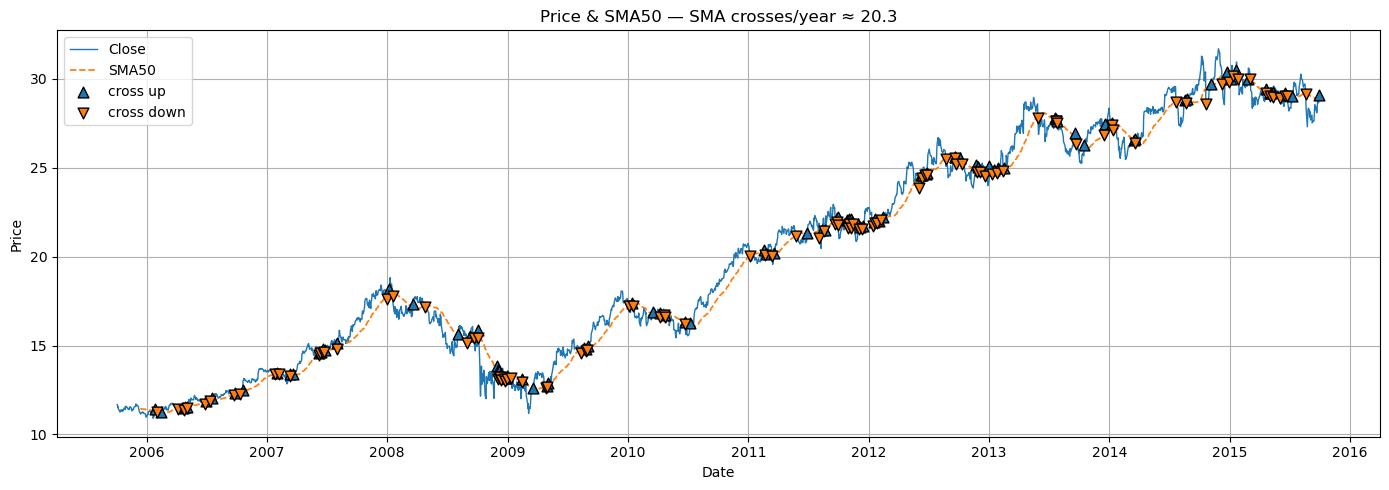

                         date  type      price        sma
0   2006-01-27 05:00:00+00:00    up  11.421795  11.300823
1   2006-01-31 05:00:00+00:00  down  11.261237  11.295836
2   2006-02-14 05:00:00+00:00    up  11.250347  11.228468
3   2006-04-06 04:00:00+00:00  down  11.428435  11.448190
4   2006-04-21 04:00:00+00:00    up  11.472291  11.469168
..                        ...   ...        ...        ...
194 2015-06-22 04:00:00+00:00    up  29.085554  29.067092
195 2015-06-23 04:00:00+00:00  down  29.013706  29.067279
196 2015-07-10 04:00:00+00:00    up  29.020878  28.969230
197 2015-08-20 04:00:00+00:00  down  29.135851  29.219054
198 2015-09-30 04:00:00+00:00    up  29.076630  28.753162

[199 rows x 4 columns]


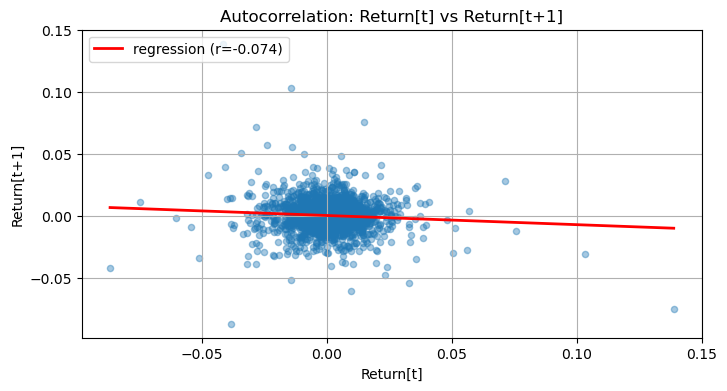

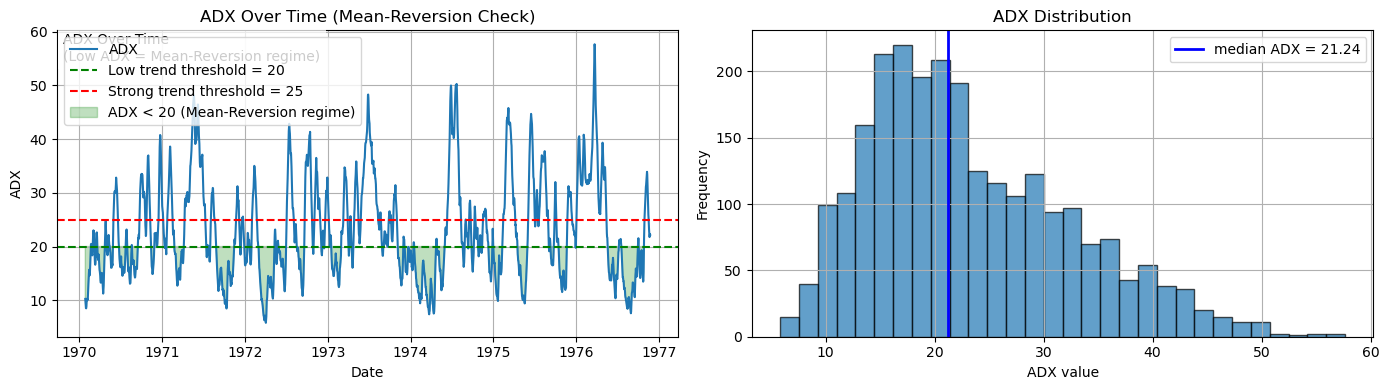

In [12]:
# # Kiểm tra cổ phiếu có pattern mean-reversion không

res = check_mean_reversion(df)
for k, v in res.items():
    print(f"{k}: {v}")

# Trực quan hóa



df_re = compute_indicators_mean_reversion(df)   
crosses = plot_price_with_sma_crosses(df_re, sma_window=50)
print(crosses)

plot_autocorrelation(df)
plot_adx_mr(df)



**Nhận xét**

- autocorr = -0.07382 < 0 : cho thấy returns có khuynh hướng đảo chiều nhẹ, không có sự nối tiếp rõ rệt.
  
- adx_median = 21.24095 > 20 => ADX trung vị lớn 20 nhưng không quá nhiều, chứng tỏ xu hướng thị trường chưa quá mạnh, không bền vững..

- total_crosses_per_year: 20.31105 => nghĩa là trung bình khoảng 1 lần cắt mỗi ~12-13 ngày giao dịch, có hơi hướng biến động ngắn hạn.

**Kết luận:** 

Cổ phiếu Coca-Cola có một số dấu hiệu mean-reversion nhưng không quá mạnh



## Phân tích Calendar Effect 
Tìm hiểu xem giá cổ phiếu có xu hướng tăng/giảm khác nhau theo thời gian cố định không ?



1. PHÂN TÍCH THEO THÁNG (MONTH EFFECT)
📊 Trung bình Return theo tháng:
 Month Month_Name  Avg_Return  Std_Dev  Total_Days
    11   November    0.166610 1.248252         204
     3      March    0.162629 0.998404         218
     9  September    0.153219 1.074646         204
     7       July    0.083274 0.985439         213
     4      April    0.076896 0.935115         207
     2   February    0.037186 1.254131         192
     5        May    0.030752 1.001567         211
    10    October    0.011487 1.889846         221
     8     August   -0.008752 1.103152         220
     6       June   -0.023378 1.019302         214
    12   December   -0.029530 1.090108         211
     1    January   -0.140652 1.063497         202
✓ Tháng tốt nhất: 11 (November) - Avg 0.1666%
✗ Tháng tồi nhất: 1 (January) - Avg -0.1407%
  Chênh lệch: 0.3073%
2. PHÂN TÍCH THEO QUÝ (QUARTER EFFECT)
📊 Trung bình Return theo quý:
Quarter  Avg_Return  Std_Dev  Total_Days
     Q3    0.073891 1.056297         637
  

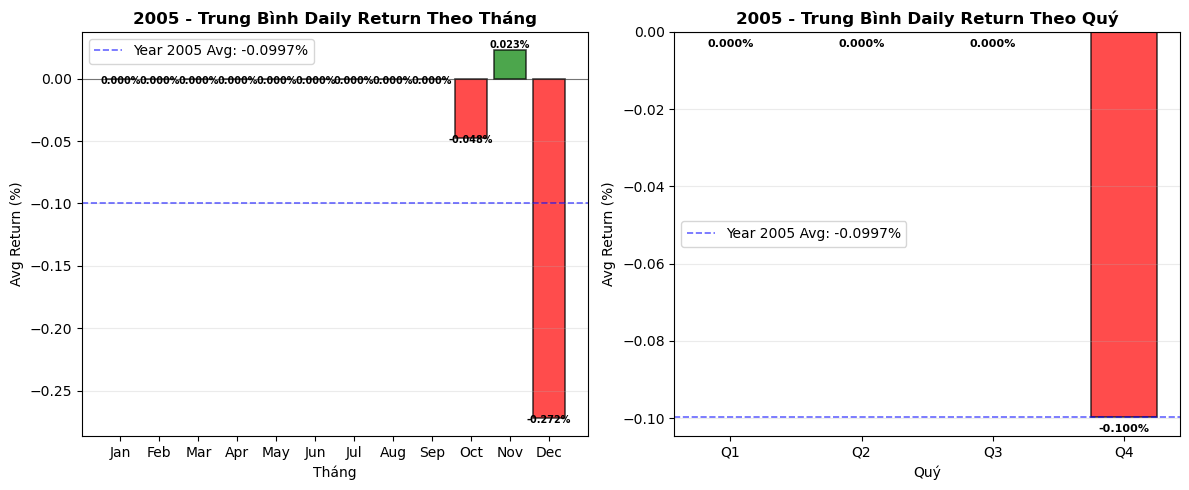

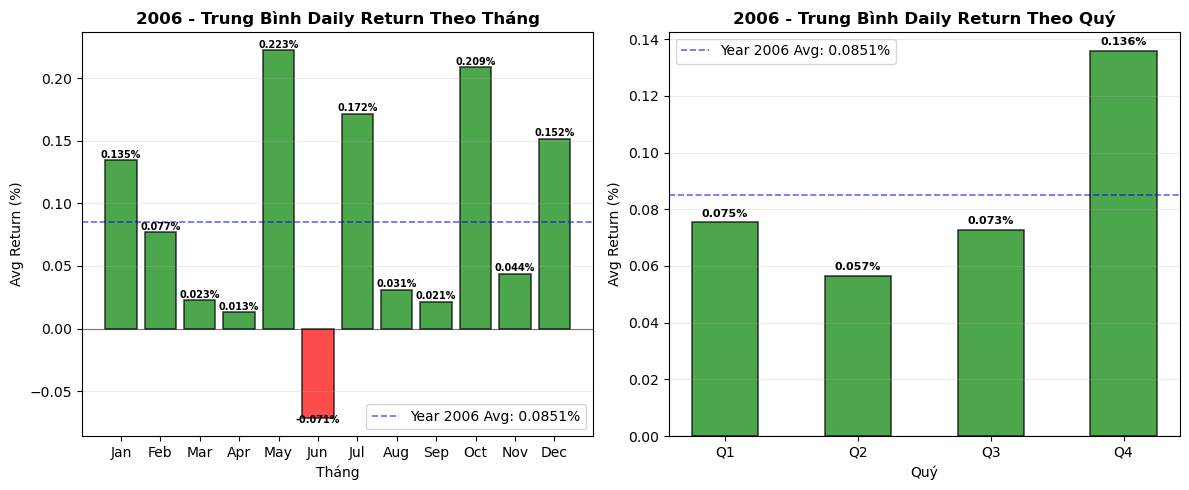

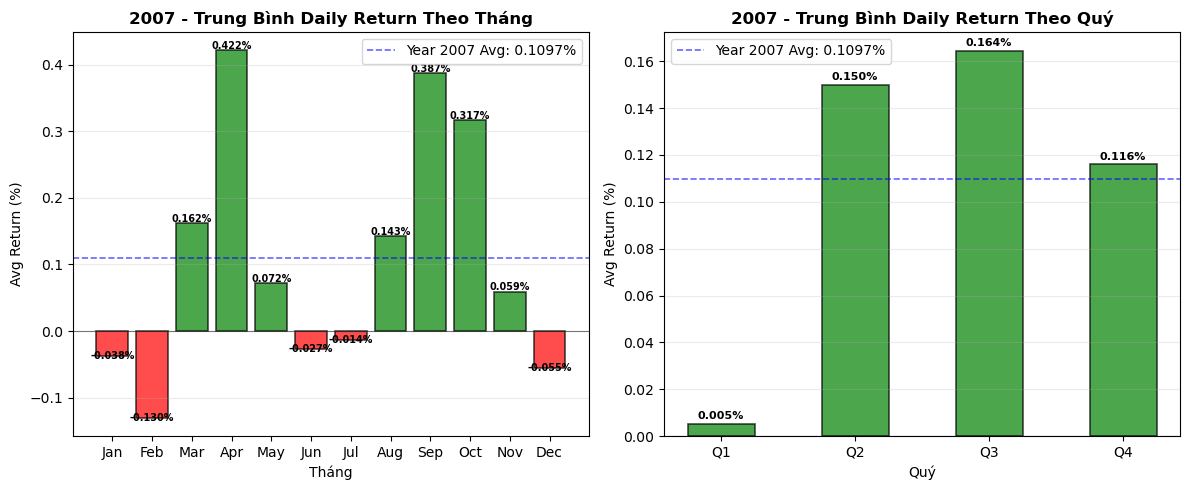

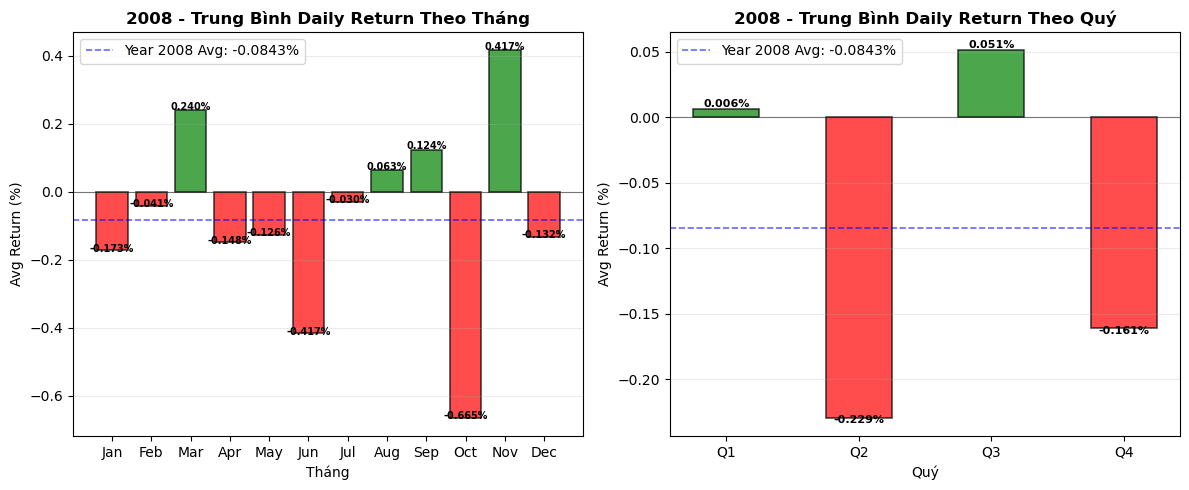

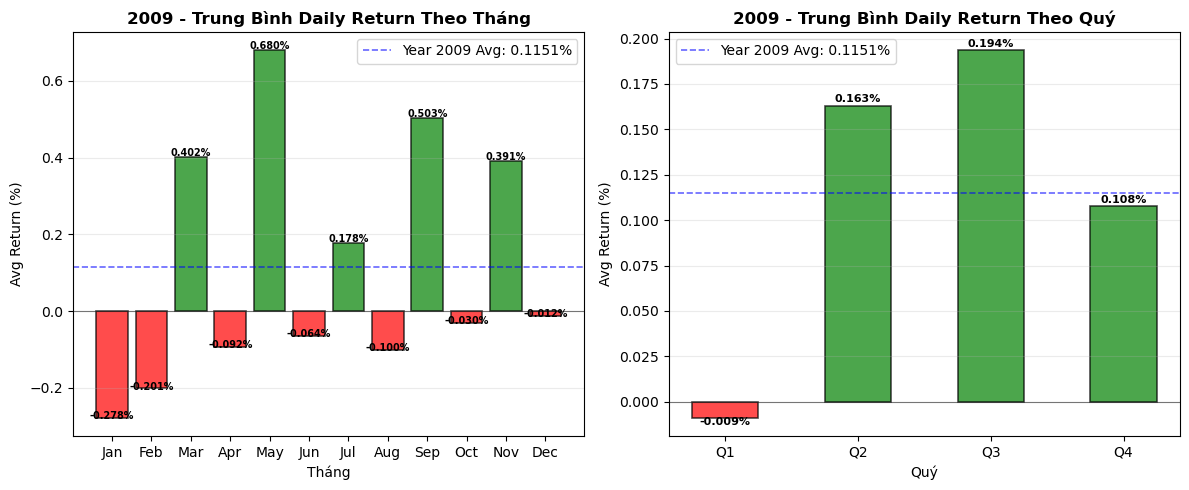

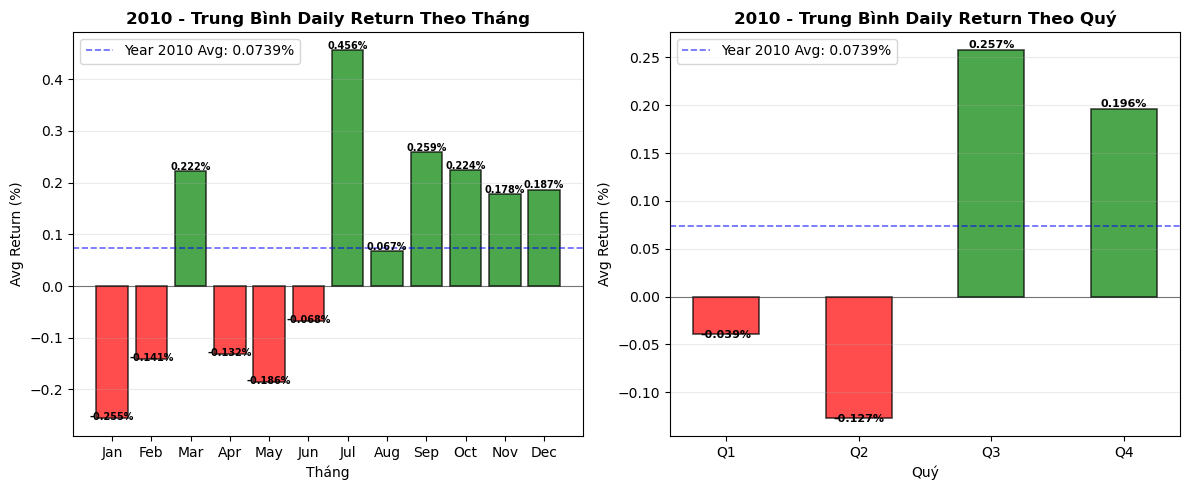

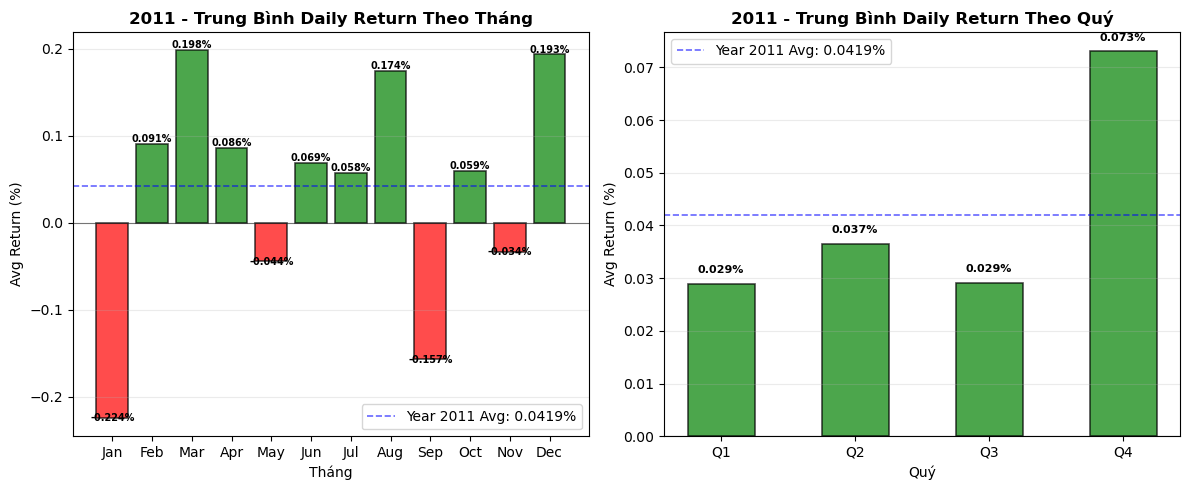

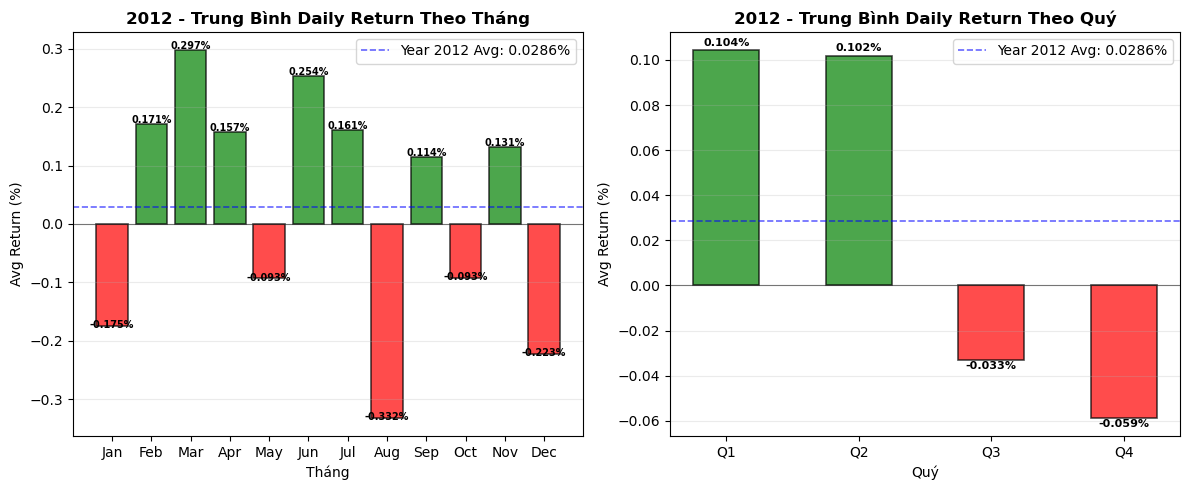

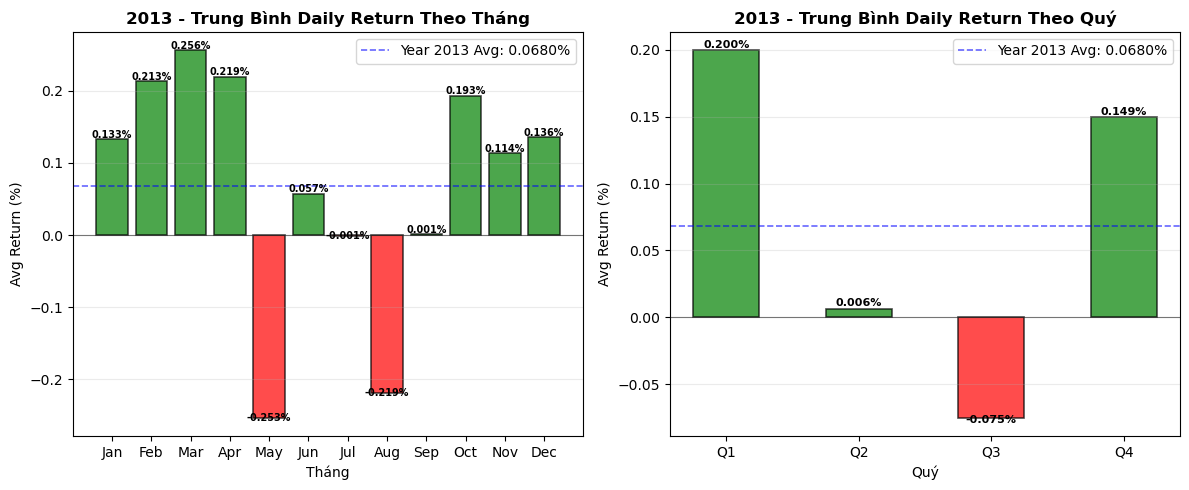

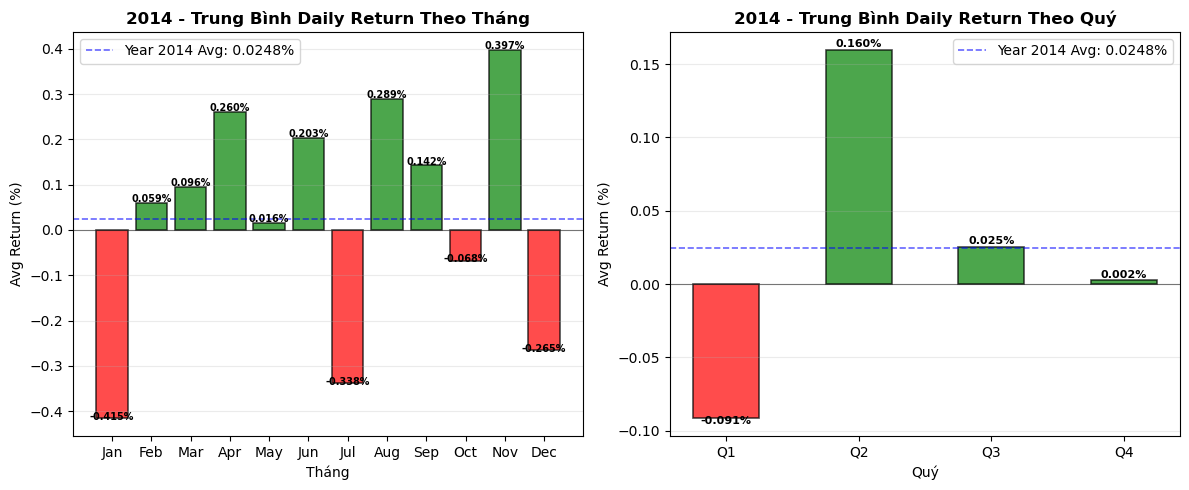

In [13]:
# Return theo từng năm theo tháng/quý
results_by_year = analyze_calendar_effects(df, per_year= True)

1. PHÂN TÍCH THEO THÁNG (MONTH EFFECT)
📊 Trung bình Return theo tháng:
 Month Month_Name  Avg_Return  Std_Dev  Total_Days
    11   November    0.166610 1.248252         204
     3      March    0.162629 0.998404         218
     9  September    0.153219 1.074646         204
     7       July    0.083274 0.985439         213
     4      April    0.076896 0.935115         207
     2   February    0.037186 1.254131         192
     5        May    0.030752 1.001567         211
    10    October    0.011487 1.889846         221
     8     August   -0.008752 1.103152         220
     6       June   -0.023378 1.019302         214
    12   December   -0.029530 1.090108         211
     1    January   -0.140652 1.063497         202
✓ Tháng tốt nhất: 11 (November) - Avg 0.1666%
✗ Tháng tồi nhất: 1 (January) - Avg -0.1407%
  Chênh lệch: 0.3073%
2. PHÂN TÍCH THEO QUÝ (QUARTER EFFECT)
📊 Trung bình Return theo quý:
Quarter  Avg_Return  Std_Dev  Total_Days
     Q3    0.073891 1.056297         637
  

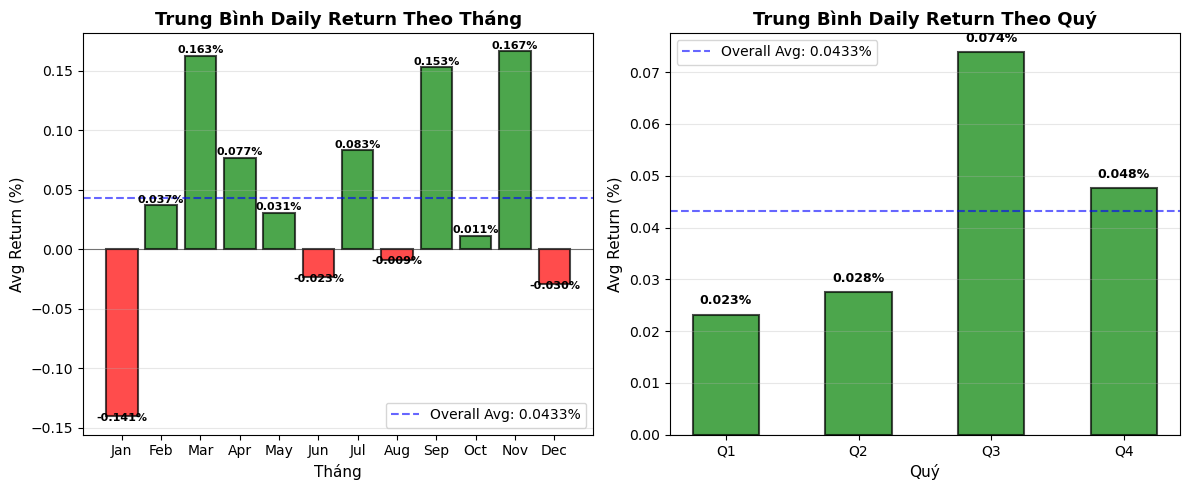

In [14]:
# Tính gộp tất cả các năm lại
results = analyze_calendar_effects(df)

**Nhận xét kết quả** 

**1. Month Effect**

- Tháng 3, 9 và 11  có daily return trung bình cao vượt trội, cao hơn rõ rệt mức trung bình toàn thị trường.

- Tháng 1 là tháng kém nhất, daily return trung bình âm sâu → rủi ro giảm giá cao.

- Các tháng 6, 8 và 12 cũng cho thấy xu hướng lợi nhuận âm, nhưng mức độ nhẹ hơn so với đầu năm

**2. Quarter Effect**

- Q3 và Q4 là những quý có daily return trung bình cao nhất
  
- Q1 và Q2 có daily return không quá vượt trội

**Kết luận chung**

- **Đầu năm (Tháng 1)**: Cổ phiếu có xu hướng tăng trưởng yếu nhất. Sau mùa tiêu thụ cao điểm cuối năm và Tết, nhu cầu tiêu dùng giảm mạnh trong thời tiết lạnh, khiến giá cổ phiếu thường chịu áp lực điều chỉnh sâu.

- **Tháng 3-5**: Sau tháng 1 và tháng 2 thường có doanh số thấp do thời tiết lạnh và giai đoạn thắt chặt chi tiêu sau Tết, tháng 3 đánh dấu sự chuyển mình sang mùa Xuân-Hè. Thị trường chứng khoán thường phản ứng trước dựa trên kỳ vọng. Nhà đầu tư bắt đầu mua vào để đón đầu mùa tiêu thụ cao điểm sắp tới. 

- **Giai đoạn cuối năm (Tháng 9 - Tháng 11)**: Là khoảng thời chuẩn bị cho các lễ hội như giáng sinh/tết. Vì lẽ đó nên cổ phiếu tăng trưởng tốt có thể là nhờ các chiến lược marketing quy mô lớn gắn liền với chủ đề lễ hội (Giáng sinh, Tết), giúp kích cầu tiêu dùng và tạo tâm lý tích cực cho các nhà đầu tư trước kỳ báo cáo cuối năm.


## Phân tích Pattern Up Down

Tìm hiểu xem thị trường có xu hướng tăng nhẹ nhiều ngày hay giảm mạnh ít ngày?


=== Up/Down Pattern Summary ===

Total days analyzed: 2517

Metric       |         Up |       Down
------------------------------------
count        |        634 |        635
mean         |       2.06 |       1.86
median       |       2.00 |       1.00
max          |         10 |          9

Transition probabilities (rows=Prev state, cols=Curr state) in %:
Daily_Return     -1      1
Daily_Return              
-1.0          46.77  53.23
 1.0          47.93  52.07



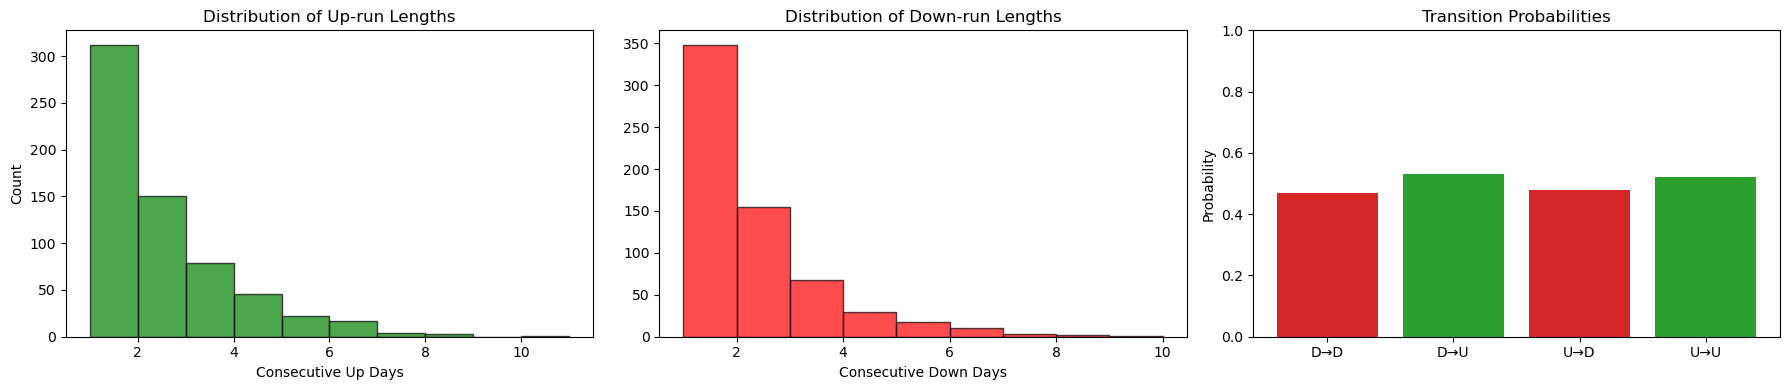

In [15]:
results_up_down = analyze_up_down(df)

**Nhận xét kết quả phân tích Up-down**

**Phân bố chuỗi ngày tăng/giảm**

- Chuỗi tăng/giảm phổ biến nhất là 2 ngày, cho thấy thị trường thường có những đợt tăng/giảm ngắn hạn.

- Tần suất giảm dần khi số ngày tăng/giảm liên tiếp tăng lên, phản ánh rằng các chuỗi tăng/giảm dài hạn là hiếm.

Nhìn chung, cổ phiếu Coca-Cola không có xu hướng tăng hoặc giảm trong dài ngày.

**Xác suất chuyển trạng thái**

- D → U = 53.23%

→ Sau khi giảm, giá có xác suất hồi phục không quá cao 

- U → U = 52.07%

→ Khi đã tăng, giá có xác suất tiếp tục tăng cũng chỉ hơi nhỉnh hơn 50% một tí khoảng 2.07% (không đáng kể)

- Cả hai xác suất (D→U và U→U) đều chỉ hơi lệch khỏi 50%.

→ Điều này cho thấy hành vi giá không thiên mạnh về trend-following, và cũng không quá thiên về mean-reversion 

**Kết luận**

Từ kết quả trên có thể nhận xét rằng KO không phải cổ phiếu có xu hướng mạnh (trend-following yếu) và mean-reversion rõ ràng



## Nhận xét tổng quát

Cổ phiếu Coca-Cola hiện không có trend mạnh và cũng không có pattern mean-reversion rõ ràng. Pattern rõ thấy nhất là pattern mùa vụ. Cổ phiếu có tăng trưởng tốt ở các giai đoạn là từ tháng 3-5 và từ tháng 9-11
